In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

seed = 123909783

In [41]:
df_nav830 = pd.read_csv("./ML_Project/ML_Project_tbl_nav830_hist_1yr.csv")
df_arch_1 = pd.read_csv("./ML_Project/ML_Project_ldos_archive_1yr (1).csv")
df_arch_2 = pd.read_csv("./ML_Project/ML_Project_ldos_archive_1yr (2).csv")
df_arch = pd.concat([df_arch_1, df_arch_2], ignore_index=True)

df_znmps = pd.read_csv("./ML_Project/ML_Project_tbl_znmps3400_1yr.csv")

In [42]:
df_arch['updated_ts'] = pd.to_datetime(df_arch['updated_ts'])
df_arch['updated'] = df_arch['updated_ts'].dt.normalize() # Get rid of time component

df_nav830['updated'] = pd.to_datetime(df_nav830['updated'])
df_nav830['company'] = df_nav830['ncmp']

In [43]:
df_nav830

,updated,qualifier,bano,item,cono,cont,supplier_alias,csel,schn,seqn,...,wk08,wk09,wk10,wk11,wk12,flx,mth4,mth5,mth6,company
0,2023-03-26,HDR,20230326015582,4122569F91,AM537A,3120,ghejd,X5,571541,0,...,16.0,18.0,17.0,20.0,14.0,44.0,197.0,112.0,114.0,65
1,2023-03-26,HDR,20230326004672,4030197C1,AB480A,2595,abiga,X1,570387,0,...,0.0,0.0,50.0,0.0,0.0,50.0,50.0,0.0,50.0,65
2,2023-03-26,HDR,20230326004929,425FTA1125,034ECA,2760,aefjc,X1,559955,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,65
3,2023-03-26,HDR,20230326008435,450RTH1685,053EAA,2335,bdhfe,X2,574317,0,...,4.0,0.0,18.0,19.0,5.0,40.0,131.0,107.0,98.0,65
4,2023-03-26,HDR,20230326010466,4368389C1,AI589A,3205,djiba,X4,560643,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921129,2022-10-30,HDR,20221030016821,7782685703,026MYA,2817,hieff,X1,686864,0,...,4.0,0.0,22.0,20.0,0.0,21.0,59.0,14.0,138.0,65
921130,2022-10-30,HDR,20221030016822,3660382C1,AZ041A,524,higbd,X1,673403,0,...,10.0,0.0,10.0,70.0,10.0,30.0,40.0,0.0,0.0,65
921131,2022-10-30,HDR,20221030016828,3840495C2,AZ041A,524,higbd,X1,680989,0,...,15.0,0.0,20.0,10.0,35.0,40.0,60.0,70.0,35.0,65
921132,2022-10-30,HDR,20221030016833,3813372C1,AZ041A,524,higbd,X1,687127,0,...,0.0,0.0,50.0,50.0,0.0,50.0,50.0,100.0,50.0,65


In [44]:
df = df_nav830.sort_values(by='updated',ascending=False)

In [45]:
df.groupby('item')

In [46]:
# Calculate Percentage Change between last week's prediction and this week's prediction
# df['prev_wk02'] = df.groupby('item')['wk02'].shift(-1)
for i in range(2, 13):
    df[f'prev_wk{i:02d}'] = df.groupby('item')[f'wk{i:02d}'].shift(-1)
    df[f'pc_wk{i-1:02d}'] = (df[f'wk{i-1:02d}'] - df[f'prev_wk{i:02d}']) / df[f'prev_wk{i:02d}'].replace(0, np.nan)
    df[f'pc_wk{i-1:02d}'] = df[f'pc_wk{i-1:02d}'].fillna(0)
    df[f'pc_wk{i-1:02d}'] = df[f'pc_wk{i-1:02d}'].clip(upper=1,lower=-1) # Ensure values are in a range

In [47]:
# Check Function
# df.loc[df['item']=='4122569F91',['updated','pc_wk01','wk01','prev_wk02','pc_wk02','wk02','prev_wk03','wk03']]
# We will want to dropna() here; these will be the records with nothing to compare with

In [48]:
pc_week_cols = [f'pc_wk{str(i).zfill(2)}' for i in range(1, 12)] # up to pc_wk11
schedule_data = df[pc_week_cols]

In [49]:
scaler = StandardScaler()
schedule_scaled = pd.DataFrame(scaler.fit_transform(schedule_data), columns=pc_week_cols)

In [50]:
# Utility Functions 
def find_optimal_clusters(data, max_k, random_state):
    wcss = []
    k_values = range(1, max_k+1)

    for k in k_values:
        kmeans = KMeans(n_init='auto', n_clusters=k, random_state=random_state)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, wcss, marker='o')
    plt.title('WCSS vs. Number of Clusters (k)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster sum of squares (WCSS)')
    plt.grid(True)
    plt.show()

def find_optimal_clusters_with_silhouette(data, max_k, random_state):
    silhouette_scores = []
    k_values = range(2, max_k+1)  # silhouette score is not defined for k=1

    for k in k_values:
        kmeans = KMeans(n_init='auto', n_clusters=k, random_state=random_state)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.title('Silhouette Score vs. Number of Clusters (k)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
def cluster_and_plot(data, n_clusters, random_state):
    # Create a KMeans instance with n_clusters
    kmeans = KMeans(n_init='auto', n_clusters=n_clusters, random_state=random_state)

    # Fit the model to the data and predict the cluster labels
    cluster_labels = kmeans.fit_predict(data)

    # Create a DataFrame with the scaled data and cluster labels
    clustered_data = data.copy()
    clustered_data['cluster'] = cluster_labels

    # Calculate the count of schedules in each cluster before melting
    cluster_counts = clustered_data['cluster'].value_counts().sort_index()
        
    # Melt the DataFrame to long format for plotting
    clustered_data_melt = pd.melt(clustered_data, id_vars=['cluster'], value_vars=data.columns, var_name='week', value_name='data')

    # Convert the 'week' column to integer for proper sorting
    clustered_data_melt['week'] = clustered_data_melt['week'].str.slice(5).astype(int) # Remove 'pc_wk'

    # Create a grid of subplots with one row for each cluster
    g = sns.FacetGrid(clustered_data_melt, col='cluster', col_wrap=2, height=4, aspect=1.5)
    
    # Plot the actual schedules for each cluster
    for ax in g.axes.flatten():
        cluster = ax.get_title().split('=')[1].strip()
        sns.lineplot(x='week', y='data', data=clustered_data_melt[clustered_data_melt['cluster'] == int(cluster)], alpha=0.7, errorbar=None, ax=ax)
        
        # Overlay the average schedule curve for each cluster
        sns.lineplot(x='week', y='data', data=clustered_data_melt[clustered_data_melt['cluster'] == int(cluster)], estimator='mean', lw=2, color='black', ax=ax)

        # Set the title to include the cluster number and count
        ax.set_title(f'Cluster {cluster} (n={cluster_counts[int(cluster)]})')
        
    g.fig.suptitle(f'12-week Schedule Patterns for {n_clusters} Clusters', y=1.02)
    plt.show()
    
    return clustered_data

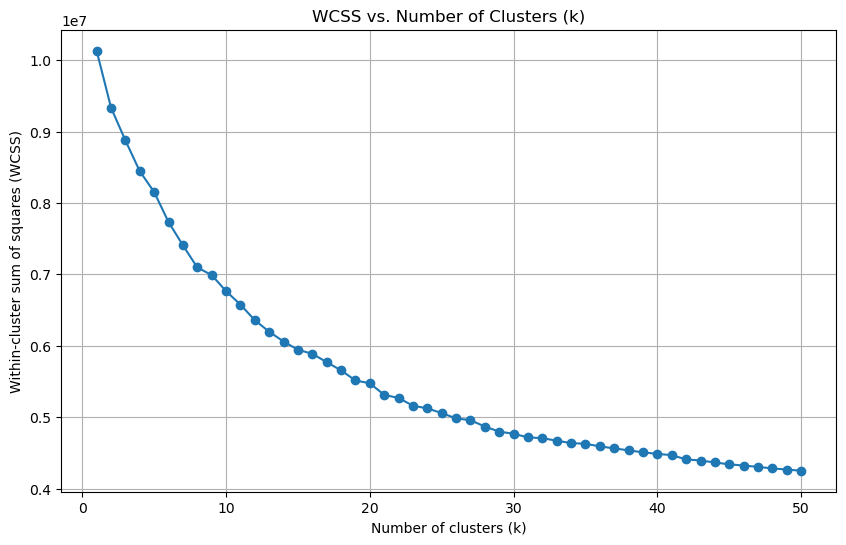

Wall time: 1min 20s


In [51]:
%%time
find_optimal_clusters(schedule_scaled, max_k=50, random_state=seed)

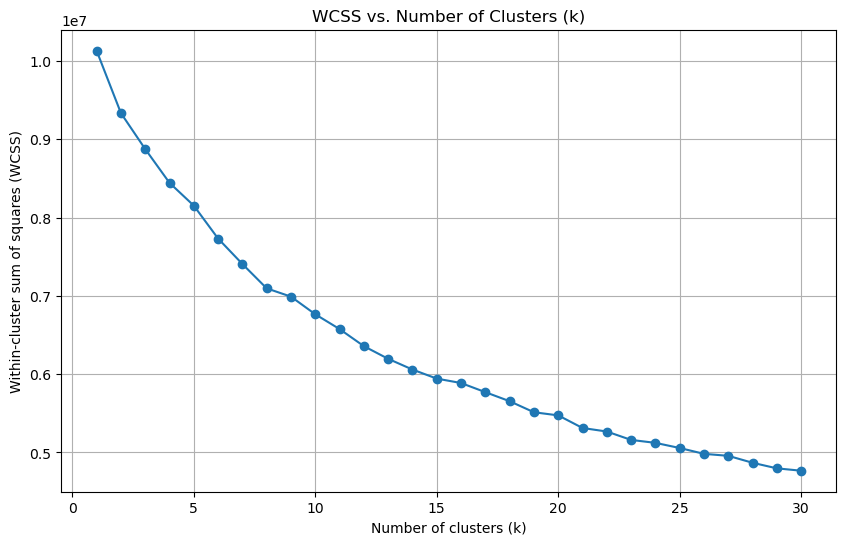

Wall time: 34.2 s


In [52]:
%%time
find_optimal_clusters(schedule_scaled, max_k=30, random_state=seed)

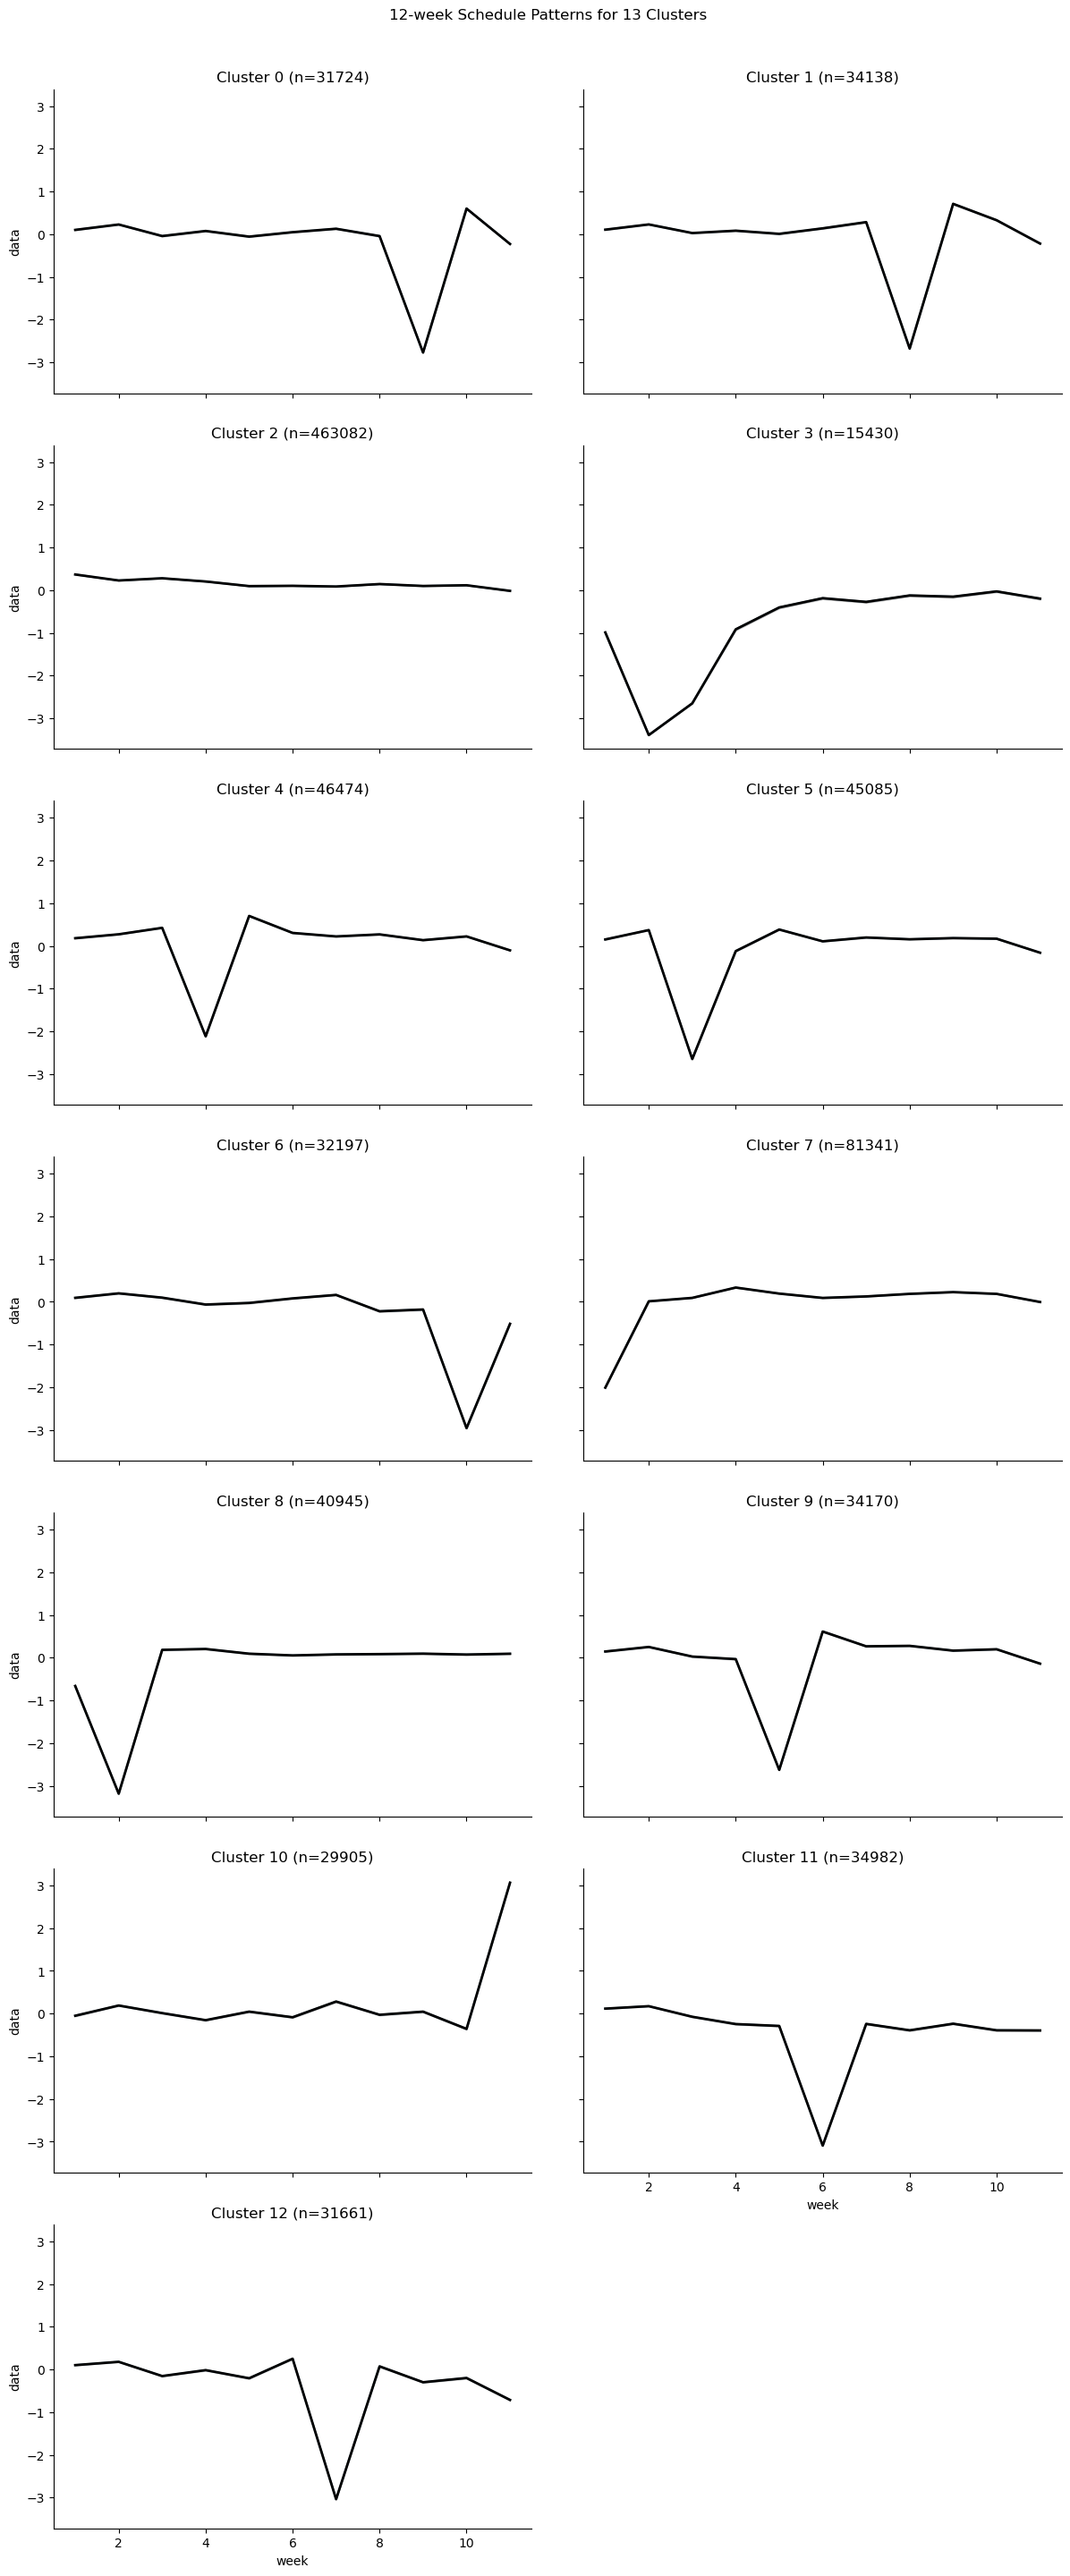

Wall time: 1min 9s


In [53]:
%%time
clustered_scaled_schedule = cluster_and_plot(schedule_scaled, n_clusters=13, random_state=seed)

In [54]:
scaler = RobustScaler()
schedule_scaled = pd.DataFrame(scaler.fit_transform(schedule_data), columns=pc_week_cols)

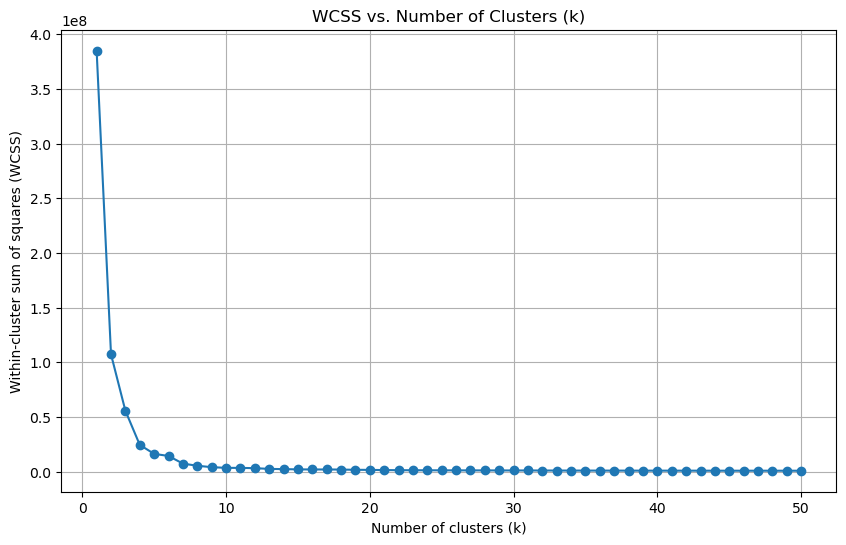

Wall time: 58.4 s


In [55]:
%%time
find_optimal_clusters(schedule_scaled, max_k=50, random_state=seed)

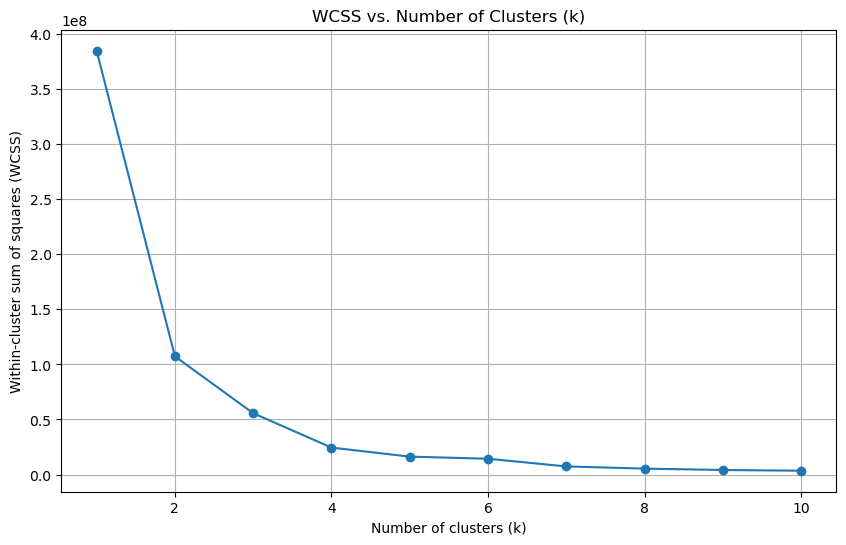

Wall time: 4.27 s


In [56]:
%%time
find_optimal_clusters(schedule_scaled, max_k=10, random_state=seed)

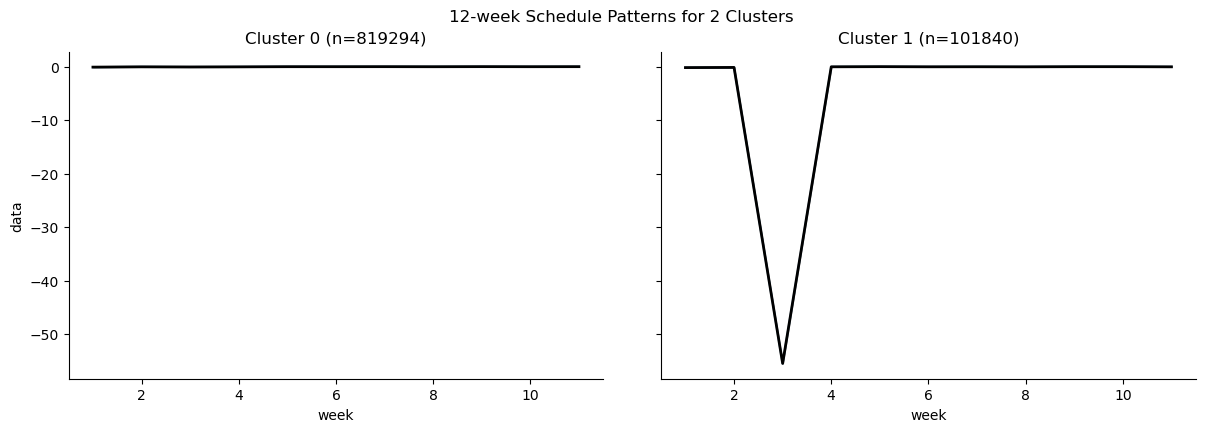

Wall time: 1min 31s


In [57]:
%%time
clustered_scaled_schedule = cluster_and_plot(schedule_scaled, n_clusters=2, random_state=seed)

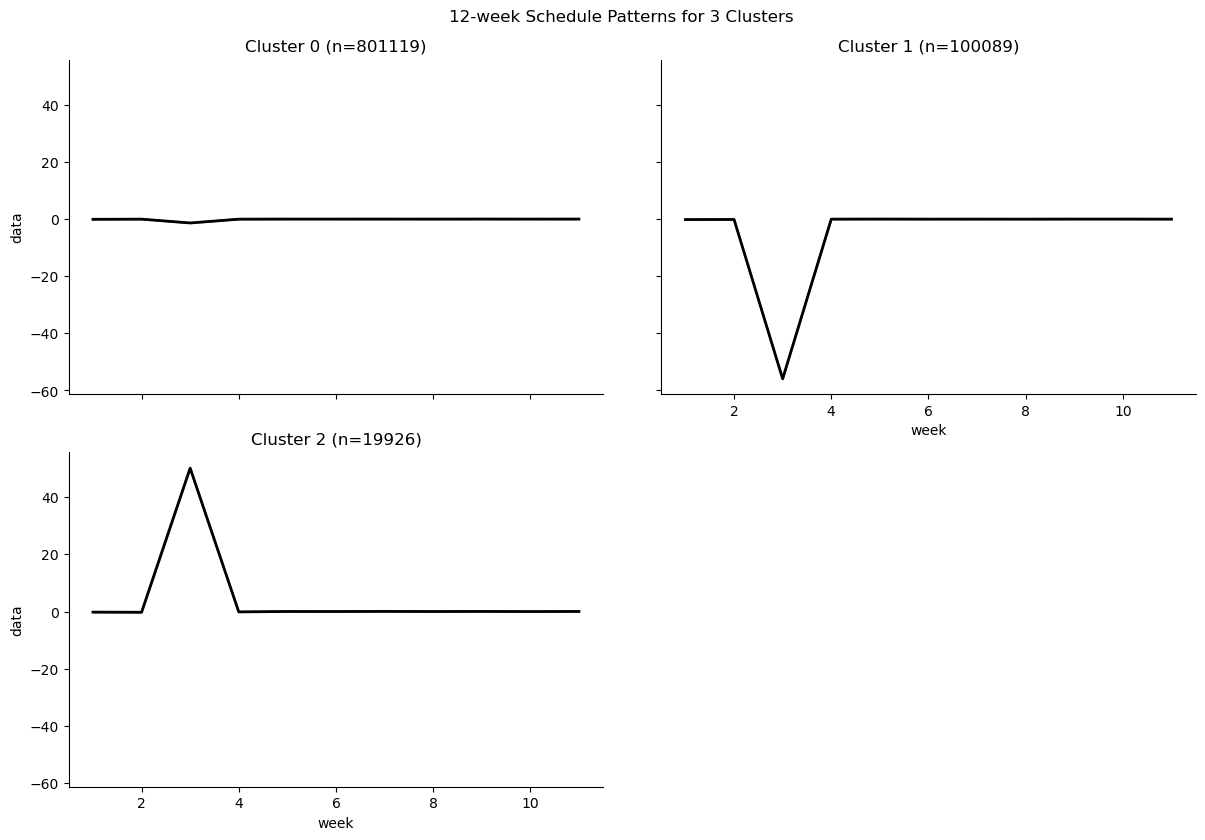

Wall time: 1min 30s


In [58]:
%%time
clustered_scaled_schedule = cluster_and_plot(schedule_scaled, n_clusters=3, random_state=seed)

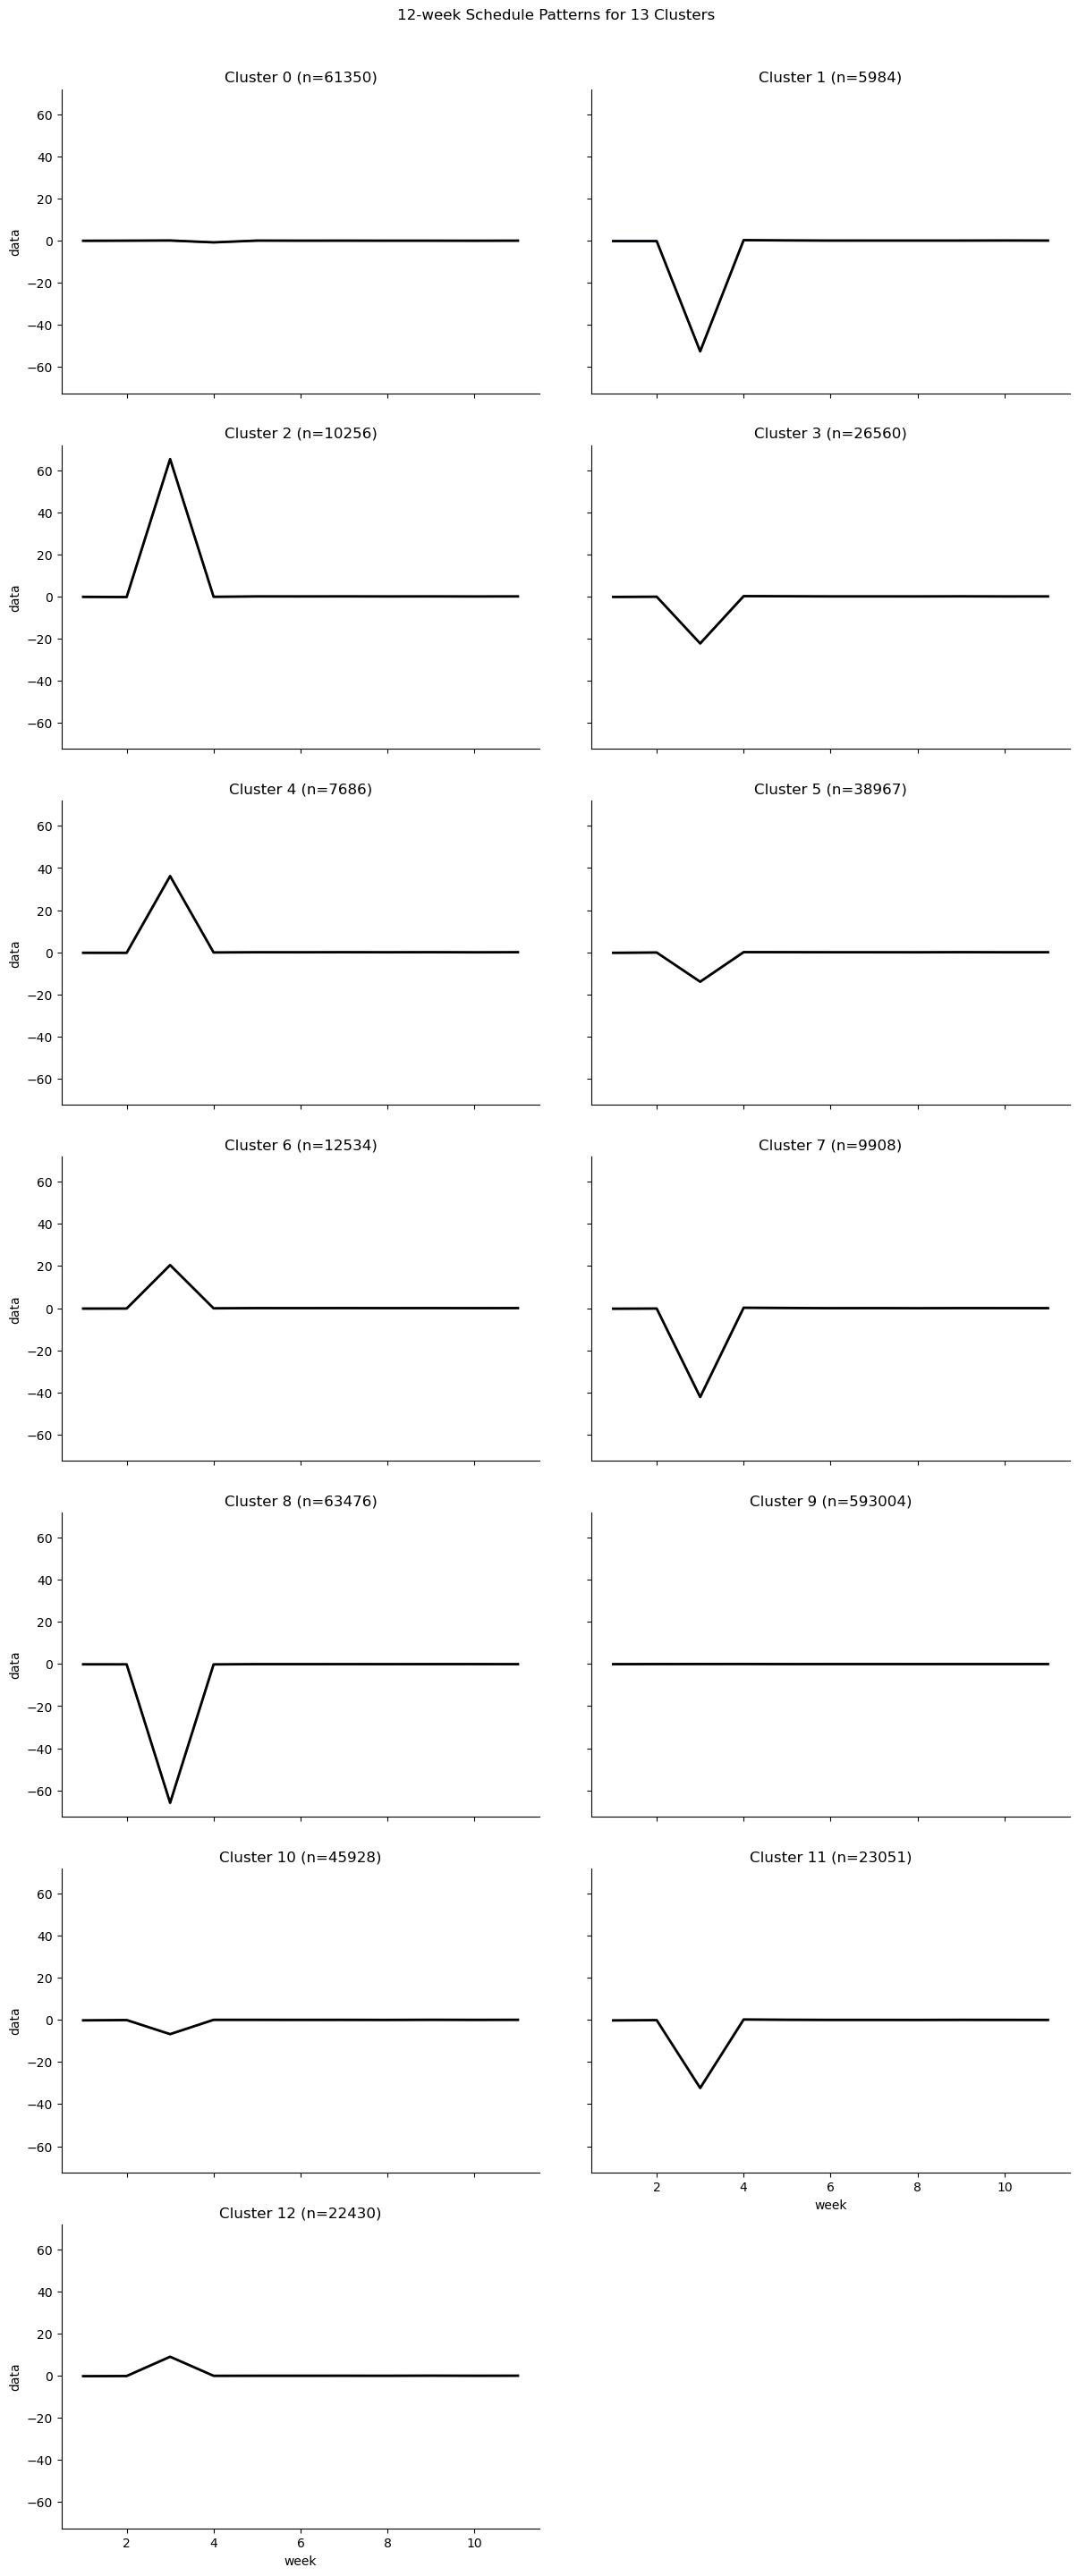

Wall time: 1min 16s


In [59]:
%%time
clustered_scaled_schedule = cluster_and_plot(schedule_scaled, n_clusters=13, random_state=seed)